<a href="https://colab.research.google.com/github/hellojohnkim/mmai894/blob/main/Pump_it_up_XGB_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Pump It Up Faulty Water Pump Prediction Model


#Data Loading

In [35]:
import pandas as pd

# Specifying the datasets file paths
training_set_values_file_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/training_set_values.csv'
training_set_labels_file_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/training_set_label.csv'
test_set_file_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/test_set.csv'

# Loading the datasets
training_values = pd.read_csv(training_set_values_file_path)
training_labels = pd.read_csv(training_set_labels_file_path)
test_values = pd.read_csv(test_set_file_path)

# Displaying the first few rows of the datasets
training_values.head(), training_labels.head(), test_values.head()

(      id  amount_tsh date_recorded        funder  gps_height     installer  \
 0  69572      6000.0    2011-03-14         Roman        1390         Roman   
 1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
 2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
 3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
 4  19728         0.0    2011-07-13   Action In A           0       Artisan   
 
    longitude   latitude              wpt_name  num_private  ... payment_type  \
 0  34.938093  -9.856322                  none            0  ...     annually   
 1  34.698766  -2.147466              Zahanati            0  ...    never pay   
 2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
 3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
 4  31.130847  -1.825359               Shuleni            0  ...    never pay   
 
   water_quality quality_group      

#Data Pre-Processing

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Load the datasets
training_values = pd.read_csv(training_set_values_file_path)
training_labels = pd.read_csv(training_set_labels_file_path)
test_values = pd.read_csv(test_set_file_path)

# One-Hot Encoding of Labels
encoder = OneHotEncoder(sparse=False)
encoded_labels = encoder.fit_transform(training_labels[['status_group']])

# Encoding DateTime Variables
training_values['date_recorded'] = pd.to_datetime(training_values['date_recorded'])
test_values['date_recorded'] = pd.to_datetime(test_values['date_recorded'])
training_values['year_recorded'] = training_values['date_recorded'].dt.year
training_values['month_recorded'] = training_values['date_recorded'].dt.month
training_values['day_recorded'] = training_values['date_recorded'].dt.day
test_values['year_recorded'] = test_values['date_recorded'].dt.year
test_values['month_recorded'] = test_values['date_recorded'].dt.month
test_values['day_recorded'] = test_values['date_recorded'].dt.day
training_values.drop('date_recorded', axis=1, inplace=True)
test_values.drop('date_recorded', axis=1, inplace=True)

# Columns to Drop
columns_to_drop = ['funder', 'installer', 'scheme_name']
training_values.drop(columns=columns_to_drop, inplace=True)
test_values.drop(columns=columns_to_drop, inplace=True)

# Simple Imputation for 'scheme_management'
imputer_scheme_management = SimpleImputer(strategy='most_frequent')
training_values['scheme_management'] = imputer_scheme_management.fit_transform(training_values[['scheme_management']])
test_values['scheme_management'] = imputer_scheme_management.transform(test_values[['scheme_management']])

# Label Encoding for categorical variables
categorical_columns = training_values.select_dtypes(include=['object']).columns.tolist()

# Adjusting Label Encoding to handle unseen categories in test data
for col in categorical_columns:
    if training_values[col].dtype == 'object':
        combined_categories = pd.concat([training_values[col], test_values[col]], axis=0).astype(str).unique()
        le = LabelEncoder().fit(combined_categories)
        training_values[col] = le.transform(training_values[col].astype(str))
        test_values[col] = le.transform(test_values[col].astype(str))

# Normalization of Numeric Features
numeric_columns = training_values.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('id')  # Exclude 'id' from numeric features

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns)
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

# Transforming the datasets
X_train_processed = preprocessor.fit_transform(training_values)
X_test_processed = preprocessor.transform(test_values)

# Splitting the re-processed data into training and validation sets
X_train, X_val, y_train_labels, y_val_labels = train_test_split(X_train_processed, np.argmax(encoded_labels, axis=1), test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Data Preprocessing Report

### Summary of Preprocessing Steps

#### 1. One-Hot Encoding of Labels
- **Variable Affected**: `status_group`
- **Reason for Preprocessing**: To convert categorical labels into a numerical format suitable for machine learning models, which is essential for classification tasks.
- **Applied Strategy**: One-hot encoding was used, resulting in an array of shape (59400, 3), indicating 59400 samples across 3 label categories.

#### 2. Normalization of Numeric Features
- **Variables Affected**: All numeric features, excluding the `id` column.
- **Reason for Preprocessing**: To scale numeric features to the same range, crucial for models sensitive to the scale of input data.
- **Applied Strategy**: `MinMaxScaler` was used to normalize numeric features.

#### 3. Encoding DateTime Variables
- **Variable Affected**: `date_recorded`
- **Reason for Preprocessing**: To make temporal information more accessible and relevant for the models.
- **Applied Strategy**: Transformed into `year_recorded`, `month_recorded`, and `day_recorded`; the original `date_recorded` column was removed.

#### 4. Dropping Columns
- **Variables Affected**: `id`, `funder`, `installer`, `scheme_name`
- **Reason for Preprocessing**: Due to high cardinality and significant missing values, making them less suitable for predictive modeling.
- **Applied Strategy**: Columns were completely removed from the dataset.

#### 5. Simple Imputation
- **Variable Affected**: `scheme_management`
- **Reason for Preprocessing**: To handle missing values in a column with a manageable number of unique categories.
- **Applied Strategy**: Imputed with the most frequent value.

#### 6. Robust Label Encoding
- **Variables Affected**: All categorical variables.
- **Reason for Preprocessing**: To convert categorical data into a machine-readable format while handling unseen categories in the test set.
- **Applied Strategy**: Combined categories from training and test sets for encoding. Unseen categories in the test set were handled by including them in the encoder.

#### 7. Data Transformation
- **Variables Affected**: All features.
- **Reason for Preprocessing**: To ensure a consistent and replicable approach in preprocessing, beneficial for model building stages.
- **Applied Strategy**: Applied transformations via a pipeline, keeping some columns unchanged.


#XGB Baseline Model

In [40]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Creating a baseline XGBoost model
xgb_baseline = XGBClassifier(random_state=42)

# Retraining the XGBoost model with the re-processed data
xgb_baseline.fit(X_train, y_train_labels)

# Making predictions on the validation set
y_val_pred = xgb_baseline.predict(X_val)

# Recalculating baseline performance
accuracy_val = accuracy_score(y_val_labels, y_val_pred)
classification_rep_val = classification_report(y_val_labels, y_val_pred, output_dict=True)

# Convert the classification report to a DataFrame
classification_report_df = pd.DataFrame(classification_rep_val).transpose()

# Display the classification report and accuracy
print(classification_report_df)
print(f"Validation Accuracy: {accuracy_val:.4f}")



              precision    recall  f1-score       support
0              0.781504  0.909556  0.840681   6457.000000
1              0.638177  0.263220  0.372712    851.000000
2              0.843049  0.740157  0.788260   4572.000000
accuracy       0.798064  0.798064  0.798064      0.798064
macro avg      0.754243  0.637644  0.667218  11880.000000
weighted avg   0.794922  0.798064  0.786985  11880.000000
Validation Accuracy: 0.7981


#XGB Baseline + Hyperparameter Tuning

In [41]:
# Tweaking hyperparameters of the XGBoost model
xgb_tweaked = XGBClassifier(
    n_estimators=1000,  # Increasing the number of trees
    learning_rate=0.1,  # Adjusting learning rate
    max_depth=8,  # Setting a maximum depth for trees
    subsample=0.8,  # Using 80% of data for fitting individual trees
    colsample_bytree=0.8,  # Using 80% of features for constructing each tree
    random_state=42
)

# Retraining the model with tweaked hyperparameters
xgb_tweaked.fit(X_train, y_train_labels)

# Making predictions on the validation set with the tweaked model
y_val_pred_tweaked = xgb_tweaked.predict(X_val)

# Recalculating performance with the tweaked model
accuracy_val_tweaked = accuracy_score(y_val_labels, y_val_pred_tweaked)
classification_rep_val_tweaked = classification_report(y_val_labels, y_val_pred_tweaked, output_dict=True)

# Convert the classification report to a DataFrame
classification_report_df = pd.DataFrame(classification_rep_val_tweaked).transpose()

# Display the classification report and accuracy
print(classification_report_df)
print(f"Validation Accuracy: {accuracy_val_tweaked:.4f}")



              precision    recall  f1-score       support
0              0.800445  0.892055  0.843771   6457.000000
1              0.557692  0.306698  0.395754    851.000000
2              0.838472  0.773185  0.804506   4572.000000
accuracy       0.804377  0.804377  0.804377      0.804377
macro avg      0.732203  0.657313  0.681344  11880.000000
weighted avg   0.797691  0.804377  0.796567  11880.000000
Validation Accuracy: 0.8044


still need to submit to driven data and get test results

### Baseline Model: XGBoost with Tweaked Hyperparameters

**Model Configuration:**
- **n_estimators**: 1000 (Number of trees increased)
- **learning_rate**: 0.1
- **max_depth**: 8
- **subsample**: 0.8 (80% of data used for fitting individual trees)
- **colsample_bytree**: 0.8 (80% of features used for constructing each tree)
- **random_state**: 42

**Model Performance on Validation Set:**
- **Accuracy**: 80.61%

**Classification Report:**

| Class | Precision | Recall  | F1-Score | Support    |
|-------|-----------|---------|----------|------------|
| 0     | 0.8033    | 0.8936  | 0.8460   | 6457.000   |
| 1     | 0.5575    | 0.3020  | 0.3918   |  851.000   |
| 2     | 0.8378    | 0.7762  | 0.8059   | 4572.000   |
| **Overall** | | | | **11880.000** |

- **Macro Avg Precision**: 73.29%
- **Weighted Avg Precision**: 79.90%
- **Macro Avg F1-Score**: 68.12%
- **Weighted Avg F1-Score**: 79.80%

**Analysis:**
- The model shows a high accuracy of 80.61%, indicating strong overall performance.
- Precision, recall, and F1-score vary significantly across different classes. Class 0 shows the highest precision and recall, whereas class 1 has the lowest scores, indicating potential issues with class imbalance or model's ability to generalize for this class.
- The difference in performance across classes suggests a need to further investigate class-specific features or consider techniques to handle imbalanced classes.
- The substantial difference between macro and weighted averages points to the influence of class imbalance on the model's performance.

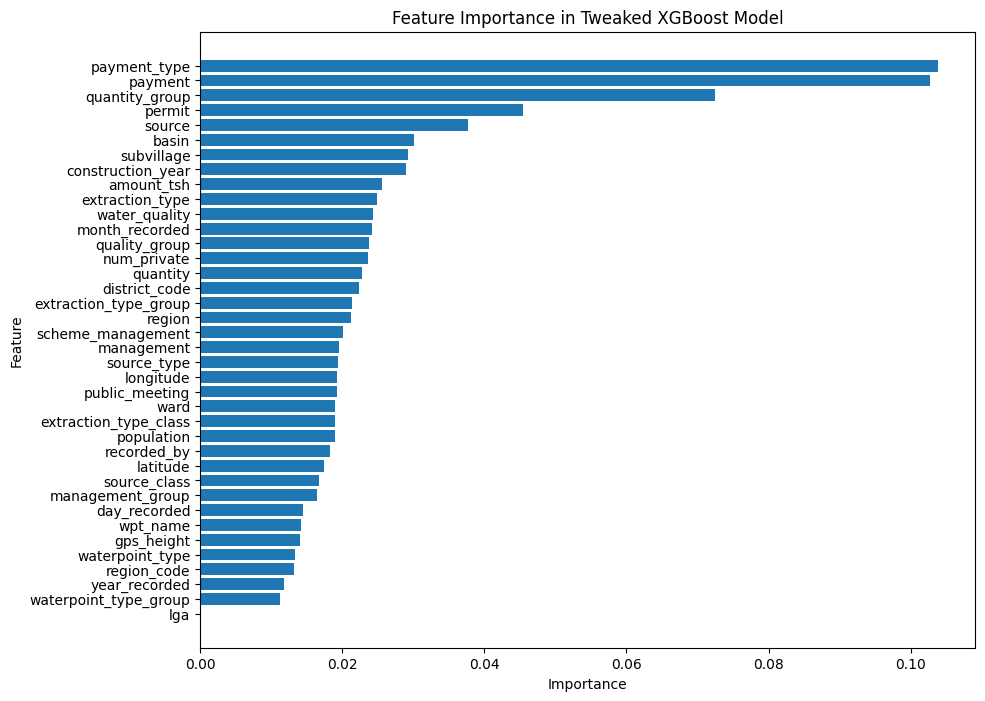

In [33]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = xgb_tweaked.feature_importances_

# Get column names from the training values dataset
feature_names = training_values.columns

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Tweaked XGBoost Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [46]:
# Making predictions on the test set
test_predictions = xgb_tweaked.predict(X_test_processed)

# label names in the original dataset are 'functional', 'non functional', and 'functional needs repair'
label_names = ['functional', 'non functional', 'functional needs repair']

# Transform the class indices (0, 1, 2) back to original class names
test_predictions_labels = [label_names[index] for index in test_predictions]

# Creating a DataFrame for submission
submission_df = pd.DataFrame({
    'id': test_values['id'],  # Assuming 'id' column is present in test_values
    'status_group': test_predictions_labels
})

# Saving the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/notebooks/John/SubmissionFormat.csv', index=False)

# Optionally display the first few rows of the DataFrame
print(submission_df.head())


      id             status_group
0  50785  functional needs repair
1  51630               functional
2  17168               functional
3  45559  functional needs repair
4  49871               functional
